622_Xiaomi

Transition matrix (6x6):
[[0.012 0.    0.    0.672 0.316 0.   ]
 [0.    0.919 0.    0.015 0.066 0.   ]
 [0.009 0.    0.    0.    0.    0.991]
 [0.071 0.    0.029 0.878 0.    0.022]
 [0.    0.009 0.    0.043 0.948 0.   ]
 [0.058 0.    0.718 0.    0.    0.224]]

State 0 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.01215, 0.4723]
  - mix 1: [+0.01641, 0.3858]

State 1 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [-0.00410, 0.7809]
  - mix 1: [+0.00508, 1.0429]

State 2 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [-0.00466, 0.3513]
  - mix 1: [-0.00197, 0.2938]

State 3 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [-0.00037, 0.4044]
  - mix 1: [-0.00079, 0.4732]

State 4 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.00382, 0.6221]
  - mix 1: [-0.00001, 0.5304]

State 5 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.00248, 0.3469]
  - mix 1: [-0

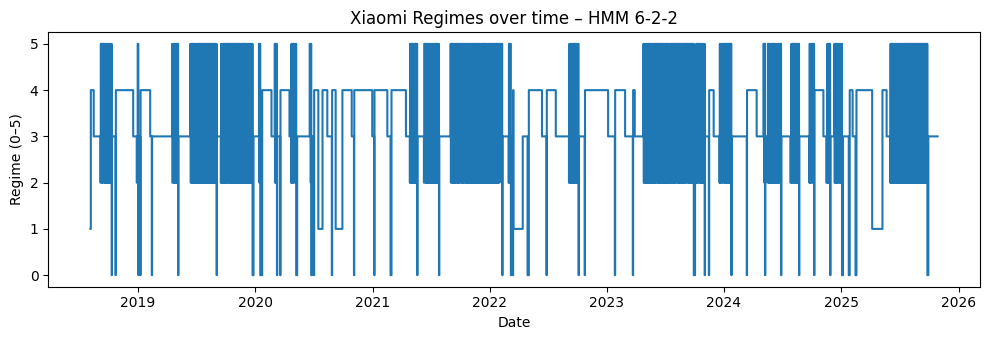

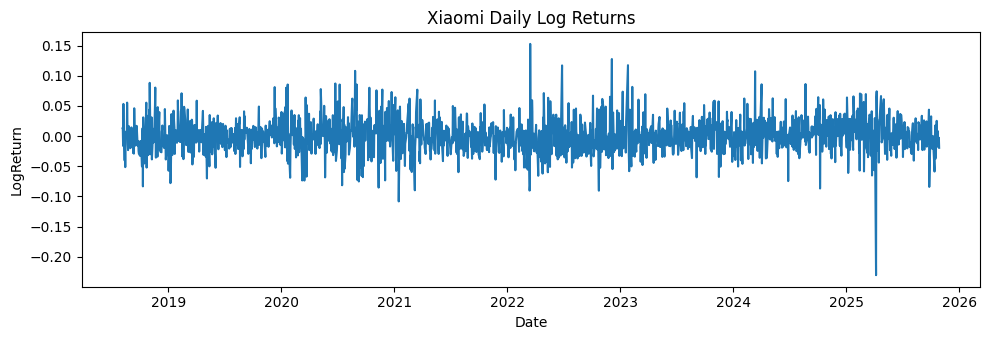

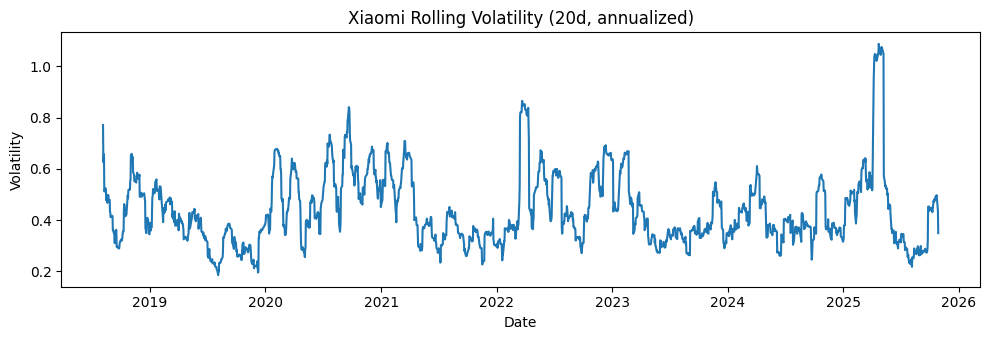

In [1]:
#Thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import os

# Load data
df = pd.read_csv(r'Xiaomi_clean.csv')
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

date_col = 'Date' if 'Date' in df.columns else [c for c in df.columns if 'date' in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

close_candidates = ['Adj_Close','AdjClose','Close','close','Price','price']
close_col = None
for c in df.columns:
    if c in close_candidates or c.lower() in ['close','adj close','adj_close','price']:
        close_col = c; break
if close_col is None:
    close_col = df.select_dtypes(include=[np.number]).columns[0]  # fallback nếu tên cột khác

# 2 feature: LogReturn & Volatility (20d, annualized)
df['LogReturn'] = np.log(df[close_col]).diff()
df['Volatility'] = df['LogReturn'].rolling(20).std() * np.sqrt(252)
df = df.dropna(subset=['LogReturn','Volatility']).reset_index(drop=True)
df.rename(columns={date_col: 'Date'}, inplace=True)

X_raw = df[['LogReturn','Volatility']].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
lengths = [len(X)]

# HMM_6:2:2
model = GMMHMM(
    n_components=6,  
    n_mix=2,         
    covariance_type='diag',
    n_iter=200, tol=1e-3,
    random_state=42, verbose=False
)
model.fit(X, lengths)

# Dự đoán Regime
df['Regime'] = model.predict(X)

# Phân tích
print("Transition matrix (6x6):")
print(np.round(model.transmat_, 3))

# Means 
for s in range(model.n_components):
    print(f"\nState {s} mixture means (LogReturn, Volatility) in original units:")
    for m in range(model.n_mix):
        mu_scaled = model.means_[s][m]                
        mu_orig = scaler.inverse_transform(mu_scaled.reshape(1,-1)).ravel()
        print(f"  - mix {m}: [{mu_orig[0]:+.5f}, {mu_orig[1]:.4f}]")

# Tỷ trọng thời gian theo Regime
share = (df['Regime'].value_counts(normalize=True).sort_index()*100).round(2)
print("\nTime share per Regime (%):")
print(share)

# Vẽ biểu đồ
plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['Regime'], drawstyle='steps-post')
plt.title('Xiaomi Regimes over time – HMM 6-2-2')
plt.xlabel('Date'); plt.ylabel('Regime (0–5)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['LogReturn'])
plt.title('Xiaomi Daily Log Returns')
plt.xlabel('Date'); plt.ylabel('LogReturn')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['Volatility'])
plt.title('Xiaomi Rolling Volatility (20d, annualized)')
plt.xlabel('Date'); plt.ylabel('Volatility')
plt.tight_layout(); plt.show()

out_path = os.path.join(os.path.dirname(r'Xiaomi_clean.csv'), 'xiaomi_hmm622_regimes.csv')
df.to_csv(out_path, index=False)
